# Anchored CoreX on STS Benchmark dataset

### Requirements

In [1]:
import numpy as np
import scipy.sparse as ss
import pandas as pd
import gensim
import csv
import pickle

from corextopic import corextopic as ct
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt

data_dir = Path("data")
assert data_dir.exists(), "data_dir does not exist."
output_dir = Path("data")
output_dir.mkdir(exist_ok=True, parents=True)

## Load the dataset

In [2]:
%%capture
sts_train = pd.read_csv(data_dir / "stsbenchmark" / 'sts-train.csv', error_bad_lines=False, header = None, delimiter="\t", quoting=csv.QUOTE_NONE, encoding='utf-8')
sts_train = sts_train.rename(columns={0: "genre", 1: "filename", 2: "year", 3: "trash", 4: "score", 5: "s1", 6: "s2"})

In [3]:
sts_train.genre = sts_train.genre.astype("category")
sts_train.filename = sts_train.filename.astype("category")
sts_train.year = sts_train.year.astype("category")
sts_train.genre = sts_train.genre.astype("category")

In [4]:
sts_train

,genre,filename,year,trash,score,s1,s2
0,main-captions,MSRvid,2012test,1,5.00,A plane is taking off.,An air plane is taking off.
1,main-captions,MSRvid,2012test,4,3.80,A man is playing a large flute.,A man is playing a flute.
2,main-captions,MSRvid,2012test,5,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,main-captions,MSRvid,2012test,6,2.60,Three men are playing chess.,Two men are playing chess.
4,main-captions,MSRvid,2012test,9,4.25,A man is playing the cello.,A man seated is playing the cello.
...,...,...,...,...,...,...,...
5547,main-news,headlines,2015,1489,1.20,"Palestinian hunger striker, Israel reach deal",Palestinian activist detained in Israeli raid
5548,main-news,headlines,2015,1493,4.80,Assad says Syria will comply with UN arms reso...,Syria's Assad vows to comply with U.N. resolution
5549,main-news,headlines,2015,1496,4.60,South Korean President Sorry For Ferry Response,S. Korean president 'sorry' for ferry disaster
5550,main-news,headlines,2015,1498,0.00,Food price hikes raise concerns in Iran,American Chris Horner wins Tour of Spain


## Vectorizer & Preprocessing

In [5]:
vectorizer = TfidfVectorizer(stop_words='english',max_features=10000,binary=True)
doc_word = vectorizer.fit_transform(pd.concat([sts_train.s1, sts_train.s2]))
doc_word = ss.csr_matrix(doc_word)
doc_word.shape # n_docs x m_words

(11104, 10000)

In [6]:
# Get words that label the columns (needed to extract readable topics and make anchoring easier)
words = list(np.asarray(vectorizer.get_feature_names_out()))

In [7]:
not_digit_idxs = [ind for ind,word in enumerate(words) if not word.isdigit()]
doc_word = doc_word[:,not_digit_idxs]
words    = [word for ind,word in enumerate(words) if not word.isdigit()]

doc_word.shape # n_docs x m_words

(11104, 9642)

In [8]:
with open(output_dir / "vectorizer.bin", "wb") as f:
    pickle.dump(vectorizer, f)

with open(output_dir / "not_digit_idxs.bin", "wb") as f:
    pickle.dump(not_digit_idxs, f)

## CoreX Topic model

In [9]:
# Train the CorEx topic model with 50 topics
topic_model = ct.Corex(n_hidden=50, words=words, max_iter=300, verbose=False, seed=1)
topic_model.fit(doc_word, words=words);

In [10]:
topic_model.save(output_dir / "topic_model.bin")

In [11]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: playing, dog, man, guitar, black, white, riding, running, horse, sitting
1: filled, wonders, vessels, said, david, brain, beckham, cisco, company, buy
2: points, index, composite, percent, originally, posted, nasdaq, ixic, exist, dow
3: treaty, amended, cfe, proliferation, europe, conventional, non, soviet, mass, ratify
4: slicing, woman, cutting, onion, potato, peeling, meat, pan, tomato, person
5: kills, drone, killed, pakistan, afghanistan, suicide, soldiers, bomb, kill, afghan
6: cents, share, profit, analysts, stock, unemployment, quarter, exchange, province, trading
7: guilty, yellen, janet, false, sachin, tendulkar, las, vegas, fraud, libertarian
8: notice, suu, kyi, nonsensical, aung, illness, deductive, things, saying, dictionary
9: magnitude, quake, earthquake, coast, hits, tropical, hurricane, usgs, storm, sandy
10: decker, double, bus, driving, wheel, ferris, hood, drives, passengers, plunge
11: toll, rises, bangladesh, death, collapse, building, navy, factory, crashes, 

In [12]:
# Print a single topic from CorEx topic model
topic_model.get_topics(topic=1, n_words=10)

[('filled', 0.005016286754741834, 1.0),
 ('wonders', 0.0049705681961236215, 1.0),
 ('vessels', 0.004794896226299633, 1.0),
 ('said', 0.0021941228993903857, 1.0),
 ('david', 0.0013350562767451399, 1.0),
 ('brain', 0.0008713031094971783, 1.0),
 ('beckham', 0.0007851159033456451, 1.0),
 ('cisco', 0.0007609624757840434, 1.0),
 ('company', 0.0007230302711440762, 1.0),
 ('buy', 0.0006970796287761391, 1.0)]

In [13]:
# Print a single topic from CorEx topic model
topic_model.get_top_docs(topic=0, n_docs=10, sort_by='log_prob')

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


[(1466, -4.128475339371107e-12),
 (830, -7.0963235287990756e-12),
 (1705, -9.320100247123264e-12),
 (1777, -1.1511014363918548e-11),
 (1200, -1.8952173164166197e-11),
 (1133, -1.8952173164166197e-11),
 (7347, -2.0686785617840542e-11),
 (1788, -3.590217012572339e-11),
 (1090, -3.781641666478208e-11),
 (6724, -3.838995787930344e-11)]

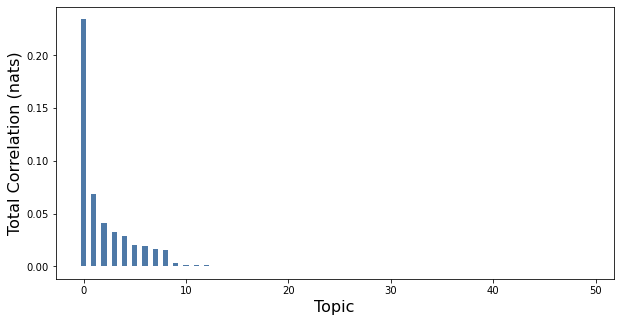

In [14]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [15]:
s1_vectorized = vectorizer.transform(sts_train.s1)
s1_vectorized = ss.csr_matrix(s1_vectorized)
s1_vectorized = s1_vectorized[:,not_digit_idxs]
s1_vectorized.shape # n_docs x m_words

(5552, 9642)

In [16]:
s1_mask = topic_model.transform(s1_vectorized, details=True)
s1_mask[0][0]

array([0.29933802, 0.00126384, 0.01671079, 0.0118553 , 0.03667859,
       0.01455063, 0.01060997, 0.0056905 , 0.00563265, 0.16651594,
       0.28768138, 0.29647752, 0.24657132, 0.28149034, 0.29084299,
       0.28159104, 0.3183846 , 0.3162301 , 0.32730847, 0.33818422,
       0.3581214 , 0.47933032, 0.40613112, 0.35178038, 0.43395846,
       0.52707819, 0.41830765, 0.45484671, 0.42137019, 0.53657627,
       0.35787469, 0.4956777 , 0.53810747, 0.45787948, 0.4980896 ,
       0.44632502, 0.56727723, 0.53614732, 0.43356897, 0.46139255,
       0.40383305, 0.54412564, 0.53654509, 0.50453291, 0.48169525,
       0.45545201, 0.46552498, 0.42461223, 0.54591812, 0.54714038])

In [17]:
s1_vectorized.shape # n_docs x m_words

(5552, 9642)